In [1]:
import warnings
import librosa
import pickle
import IPython.display as ipd
from librosa import display as libdis

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf 
import sklearn
import pickle
from tqdm import tqdm
from time import sleep
from tensorflow import keras
from keras import Sequential

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

import os
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
audio_path = "/content/drive/MyDrive/Colab Notebooks/Exp2_per-note_training/"

In [4]:
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [5]:
class Audiofile:
  def __init__(self,x,sr,f,do_calc=False):
    self.name = f
    self.x = x
    self.sr = sr
    if do_calc:
      self.stft = librosa.stft(x)
      self.spect = librosa.amplitude_to_db(abs(self.stft))
      self.mfccs = librosa.feature.mfcc(x, sr=sr)
      self.zero_crossings = librosa.zero_crossings(x, pad=False)
      self.sc = np.trim_zeros(librosa.feature.spectral_centroid(x, sr=sr)[0])
      self.sc_norm = sklearn.preprocessing.minmax_scale(self.sc, axis=0)
      frames = range(len(self.sc))
      self.time = librosa.frames_to_time(frames)
  
  def getSpectrogram(self,min_size):
    self.stft = librosa.stft(self.x[:min_size])
    self.spect = librosa.amplitude_to_db(abs(self.stft))
    return self.spect
  
  def getMfccs(self,min_size):
    self.mfccs = librosa.feature.mfcc(self.x[:min_size], sr=self.sr, n_fft=1024)
    return self.mfccs
  
  def getZerocrossings(self,min_size):
    self.zero_crossings = librosa.zero_crossings(self.x[:min_size], pad=False)
    return self.zero_crossings
  
  def getSpectralCentroid(self,min_size):
    self.sc = np.trim_zeros(librosa.feature.spectral_centroid(self.x[:min_size], sr=self.sr)[0])
    self.sc_norm = sklearn.preprocessing.minmax_scale(self.sc, axis=0)
    frames = range(len(self.sc))
    self.time = librosa.frames_to_time(frames)
    return self.sc_norm


In [6]:
# load the MIDI dataset 
f=open(audio_path+'all-notes.dat','rb')
all_notes = pickle.load(f)


In [7]:
# use test data set 
# path = 'notes/'
# file_list = os.listdir(path)


In [8]:
gc.disable()
warnings.filterwarnings('ignore')
raw_audios = []  
minshape = 999999999999999999999
minindex = -1

counter = 0
# Use for load a smaller dataset: 'notes'
# for i in tqdm(file_list):
#   x , sr = librosa.load(path+i)
#   if (not np.min(np.abs(x))-np.max(np.abs(x))==0):
#     if x.shape[0]<minshape:
#       minshape = x.shape[0]
#       minindex = counter
#     counter+=1 
#     raw_audios.append(Audiofile(x,sr,i.split("_")[0]))

# Use for load a dataset from MIDI generator: all-notes.dat
maxVol = 0
for ind,x in enumerate(tqdm(all_notes)):
  # if (np.max(np.abs(x[0]))-np.min(np.abs(x[0]))>8e-9):
  #   # print(np.abs(np.min(x[0])-np.max(x[0])))
  #   # print(ind,np.var(x[0]))
  #   if np.max(np.abs(x[0]))>maxVol:
  #     maxVol=np.max(np.abs(x[0]))
  if x[0].shape[0]<minshape:
    minshape = x[0].shape[0]
    minindex = counter
  counter+=1 
  raw_audios.append(Audiofile(x[0],x[1],x[2]))
warnings.filterwarnings('default')

100%|██████████| 3469/3469 [00:00<00:00, 349307.16it/s]


In [9]:
len(raw_audios)

3469

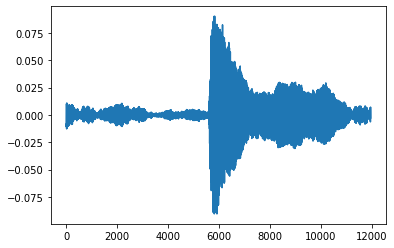

In [10]:
num= 110
plt.plot(raw_audios[num].x)
import IPython.display as ipd
# ipd.Audio(split_list[0],rate=a.sr)
ipd.Audio(raw_audios[num].x,rate=raw_audios[num].sr) 

In [11]:
ReadFromAudioFile=False

In [12]:
audios = []
if not ReadFromAudioFile:
  for i in tqdm(raw_audios):
    # for i in raw_audios:
    # start=0
    # end=0 
    # for ind,j in enumerate(i.x):
    #   if abs(j) > 0.5:
    #     start = ind
    #     break
    # for ind,j in enumerate(np.flip(i.x)):
    #   if abs(j) >0.5:
    #     end=ind
    #     break
        # print(t)
    # print(j,start,end)
    audios.append(Audiofile(i.x,i.sr,i.name))
    # ReadFromAudioFile=True
else:
  f=open(audio_path+'trimed_audio.dat','rb')
  audios=pickle.load(f)
  f.close()
gc.enable()

100%|██████████| 3469/3469 [00:00<00:00, 488272.78it/s]


In [13]:
audios[0].x

array([-6.4142409e-06, -8.5608972e-06,  3.9067635e-07, ...,
        3.1139108e-03,  1.0958064e-03,  1.6523225e-03], dtype=float32)

In [14]:
with open(audio_path+'trimed_audio.dat','wb') as f:
  pickle.dump(audios,f)

In [15]:
len(audios)

3469

In [16]:
l=[]
for i in audios:
  l.append(i.x.shape[0])
minshape=np.min(l)
for ind, x in enumerate(tqdm(audios)):
  audios[ind].x = audios[ind].x[:minshape]


100%|██████████| 3469/3469 [00:00<00:00, 546111.20it/s]


In [17]:
audios[0].x.shape,len(audios)

((11429,), 3469)

In [18]:
notes=[]
note_sym = []
for i in audios:
  note=i.name
  notes.append(note)
  if not note in note_sym:
    note_sym.append(note)

# for i in range(len(notes)):
#   notes[i] = i

In [19]:
len(notes),len(note_sym)

(3469, 58)

In [20]:
xlist = []
dup_xlist=[]
times = 1
for i,j in zip(audios,notes):
  xlist.append([i,j])

for i in range(times):
  for j in xlist:
    dup_xlist.append([j[0],j[1]])
dup_xlist = np.array(dup_xlist)
dup_xlist.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


(3469, 2)

In [21]:
readData = False

In [22]:
cut = len(dup_xlist)*2//10
x_train=[]
y_train=[]
x_val=[]
y_val=[]

if not readData:
  for i in tqdm(dup_xlist[cut:]):
    x_train.append(i[0].getMfccs(minshape))
    y_train.append(i[1])

  for i in tqdm(dup_xlist[:cut]):
    x_val.append(i[0].getMfccs(minshape))
    y_val.append(i[1])

  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_val = np.array(x_val)
  y_val = np.array(y_val)

  with open('trains.dat','wb') as ft, open('vals.dat','wb') as fv:
    pickle.dump([x_train,y_train],ft)
    pickle.dump([x_val,y_val],fv)
    ft.close()
    fv.close()
  readData = True
else:
  ft=open('trains.dat','rb')
  fv=open('vals.dat','rb')
  x_train,y_train = pickle.load(ft)
  x_val,y_val = pickle.load(fv)
  ft.close()
  fv.close()

100%|██████████| 693/693 [00:04<00:00, 172.47it/s]


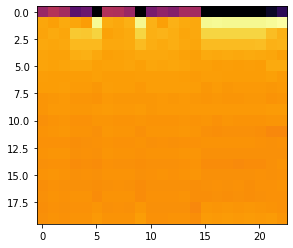

In [23]:
plt.imshow(x_train[0],cmap='inferno')

In [24]:
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(2776, 20, 23) (2776, 1)
(693, 20, 23) (693, 1)


In [26]:
with strategy.scope():
  model = Sequential([
      layers.Reshape((x_train.shape[1],x_train.shape[2],1)),
      layers.Conv2D(256,kernel_size=(2,2),activation='relu',name='conv1'),
      layers.Dropout(0.25),
      layers.Conv2D(256,kernel_size=(2,2),activation='relu',name='conv2'),
      layers.Dropout(0.25),
      # layers.Conv2D(32,kernel_size=(2,2),activation='relu',name='conv2'),
      # layers.Conv2D(32,kernel_size=(2,2),activation='relu',name='conv3'),
      layers.Flatten(),
      layers.Dense(2048,activation='relu'),
      layers.Dropout(0.25),
      layers.Dense(1024,activation='relu'),
      layers.Dense(512,activation='relu'),
      layers.Dense(60,activation='softmax')
  ])
  model.build(x_train.shape)
  model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(),metrics=['acc'])
  model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (2776, 20, 23, 1)         0         
                                                                 
 conv1 (Conv2D)              (2776, 19, 22, 256)       1280      
                                                                 
 dropout_3 (Dropout)         (2776, 19, 22, 256)       0         
                                                                 
 conv2 (Conv2D)              (2776, 18, 21, 256)       262400    
                                                                 
 dropout_4 (Dropout)         (2776, 18, 21, 256)       0         
                                                                 
 flatten_1 (Flatten)         (2776, 96768)             0         
                                                                 
 dense_4 (Dense)             (2776, 2048)             

In [ ]:
load_Model = True

In [ ]:
load_Model = False

In [ ]:
if not load_Model:
  hist = model.fit(x_train,y_train,
            epochs=80,
            shuffle=True,
            validation_data=(x_val, y_val))
  from zipfile import ZipFile
  model.save("A-so-called-good-model")      
  with ZipFile('zip_model.zip','w') as zipf:
    for file_name in os.listdir('A-so-called-good-model'):
            print(file_name)
            zipf.write('A-so-called-good-model/'+file_name)
  load_Model = True
else:
  model = keras.models.load_model('A-so-called-good-model')

Epoch 1/80
87/87 [==============================] - 12s 35ms/step - loss: 6.8508 - acc: 0.2226 - val_loss: 2.8444 - val_acc: 0.2987
Epoch 2/80
87/87 [==============================] - 3s 31ms/step - loss: 1.8085 - acc: 0.4683 - val_loss: 2.8417 - val_acc: 0.3810
Epoch 3/80
87/87 [==============================] - 3s 31ms/step - loss: 1.5981 - acc: 0.5249 - val_loss: 2.6897 - val_acc: 0.3694
Epoch 4/80
87/87 [==============================] - 3s 31ms/step - loss: 1.4146 - acc: 0.5666 - val_loss: 2.9114 - val_acc: 0.3882
Epoch 5/80
87/87 [==============================] - 3s 31ms/step - loss: 1.2513 - acc: 0.6048 - val_loss: 2.8378 - val_acc: 0.4199
Epoch 6/80
87/87 [==============================] - 3s 31ms/step - loss: 1.0395 - acc: 0.6729 - val_loss: 3.1932 - val_acc: 0.4300
Epoch 7/80
87/87 [==============================] - 3s 31ms/step - loss: 0.8190 - acc: 0.7453 - val_loss: 2.8528 - val_acc: 0.4935
Epoch 8/80
87/87 [==============================] - 3s 31ms/step - loss: 0.5762 - 

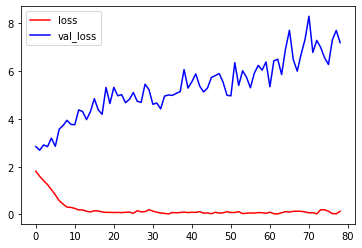

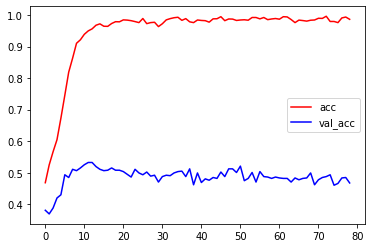

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(loss[1:],'r')
plt.plot(val_loss[1:],'b')
plt.legend(['loss','val_loss'])
plt.show()

acc = hist.history['acc']
val_acc = hist.history['val_acc']
plt.plot(acc[1:],'r')
plt.plot(val_acc[1:],'b')
plt.legend(['acc','val_acc'])
plt.show()


In [ ]:
test_file = "a#-1_98.wav"
x , sr = librosa.load(path+test_file)
a = Audiofile(x,sr,test_file.split("_")[0])
x_test = a.getMfccs(minshape)
print(x_test.shape)
plt.imshow(x_test)
plt.show()


x_test = np.array(x_test).reshape((1,x_test.shape[0],x_test.shape[1]))
res = model.predict(x_test)



In [ ]:
import IPython.display as ipd
# ipd.Audio(split_list[0],rate=a.sr)
ipd.Audio(audios[2].x,rate=audios[2].sr) 

In [ ]:
from scipy import signal
# test_wav = "Walts_of_flowers.wav"
test_wav = "Canon-in-C.mp3"
x , sr = librosa.load(test_wav)
x=np.array(x)

peaks = signal.find_peaks(x,height=0)
# maximums = signal.argrelextrema(x, np.greater)
# maximums = maximums[0]
# # maxis = [i for i in maximums if x[i] > 0.2]
# cqt = np.abs(librosa.cqt(x, sr=sr, fmin=librosa.note_to_hz('C2'),
#                 n_bins=60 * 2, bins_per_octave=12 * 2))
onset_env = librosa.onset.onset_strength(x, sr=sr)
tempo1 = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
lx = []
for i in audios[:100]:
  lx=[*lx,*i.x]
lx=np.array(lx)
onset_env = librosa.onset.onset_strength(lx, sr=audios[0].sr,)
tempo2 = librosa.beat.tempo(onset_envelope=onset_env, sr=audios[0].sr)[0]

# plt.imshow(cqt)
# plt.plot(x)
# plt.plot(maxis,x[maxis],'x')
# peaks = peaks[0]
# plt.plot(peaks,x[peaks],'x')
# plt.show()
print(tempo1,tempo2)
print(tempo1/tempo2)
# cqt

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/audioread/__init__.py:86: ResourceWarning: unclosed file <_io.BufferedReader name=83>
  if ffdec.available():
/usr/local/lib/python3.7/dist-packages/audioread/__init__.py:86: ResourceWarning: unclosed file <_io.BufferedReader name=85>
  if ffdec.available():


143.5546875 123.046875
1.1666666666666667


In [ ]:
ReadMFCC = False
# ReadMFCC = True

In [ ]:
if not ReadMFCC:
  with strategy.scope():
    # test_wav = "Walts_of_flowers.wav"
    # x , sr = librosa.load(test_wav)
    if tempo1<=tempo2:
      x_slow = librosa.effects.time_stretch(x,tempo1/tempo2)
    else:
      x_slow = librosa.effects.time_stretch(x,tempo2/tempo1)
    a = Audiofile(x_slow,sr,"test") 
    # a = Audiofile(x,sr,"Walts_of_flowers.wav") 

    # chips =  a.x.shape[0]//s.x.shape[0]
    mfs=[]
    slide = minshape
    step_size = 100
    for i in tqdm(range(0,len(a.x),step_size)):#len(a.x)):
      if i+slide<=len(a.x):
        samp = a.x[i:i+slide]
        mf = Audiofile(samp,a.sr,str(i)).getMfccs(minshape)
        mfs.append(mf)
      # conf = model.predict(mf) 

    # confs.append([np.max(conf),note_sym[np.argmax(conf)]])
    mfs = np.array(mfs)
else:
  with open(audio_path+'mfs.dat','rb') as f:
    mfs = pickle.load(f)

100%|██████████| 80879/80879 [32:22<00:00, 41.63it/s]


In [ ]:
mfs.shape

(80765, 20, 23)

In [ ]:
with open(audio_path+'mfs.dat','wb') as f:
  pickle.dump(mfs,f)
  f.close() 

In [ ]:
ac = model.predict(mfs)

AttributeError: ignored

In [ ]:
ac.shape

(80765, 128)

In [ ]:
confs=[]
for i in ac:
  if i[np.argmax(i)] >=0.99:
    confs.append(note_sym[np.argmax(i)-1])
# len(confs)

IndexError: ignored

In [ ]:
midi_note= []
for i in confs:
  midi_note.append(librosa.note_to_midi(i))

import csv 

with open("out.csv",'w',newline='') as f:
  cf = csv.writer(f)
  cf.writerows([midi_note])
f.close()